In [52]:
# Optional: import local development version of Cobra:
import sys
import os
sys.path.append(r"C:\Users\hendrik.dewinter\PycharmProjects\cobra")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tutorial for Linear Regression

This section we will walk you through all the required steps to build a predictive linear regression model using **Cobra**. All classes and functions used here are well-documented. In case you want more information on a class or function, run the next cell:

In [53]:
#help(function_or_class_you_want_info_from)

Building a good model involves three steps

1. **Preprocessing**: properly prepare the predictors (a synonym for “feature” or variable that we use throughout this tutorial) for modelling.

2. **Feature Selection**: automatically select a subset of predictors which contribute most to the target variable or output in which you are interested.

3. **Model Evaluation**: once a model has been build, a detailed evaluation can be performed by computing all sorts of evaluation metrics.



Let's dive in!!!
***

## Miles Per Gallon Prediction
- GOAL : Predict the distance, measured in miles, that a car can travel per gallon of fuel
- BASETABLE : seaborn dataset MPG

import the necessary libraries

In [54]:
import json
import pandas as pd
import numpy as np

from pandas.api.types import is_datetime64_any_dtype

pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 50)
from cobra.preprocessing import PreProcessor
from cobra.evaluation import generate_pig_tables, plot_incidence
from cobra.evaluation import evaluator

In [55]:
import seaborn as sns
df=sns.load_dataset('mpg')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In the example below, we assume the data for model building is available in a pandas DataFrame. This DataFrame should contain a an ID column, a target column (e.g. “**mpg**”) and a number of candidate predictors (features) to build a model with.

***


In [56]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin           object
name             object
dtype: object

it is required to set all category vars to object dtype


In [57]:
df.loc[:, df.dtypes == 'category'] =\
    df.select_dtypes(['category'])\
    .apply(lambda x: x.astype('object'))

## Data preprocessing

#### The first part focusses on preparing the predictors for modelling by:

1. Defining the ID column, the target, discrete and contineous variables

2. Splitting the dataset into training, selection and validation datasets.

3. Binning continuous variables into discrete intervals

4. Replacing missing values of both categorical and continuous variables (which are now binned) with an additional “Missing” bin/category

5. Regrouping categories in new category “other”

6. Replacing bins/categories with their corresponding incidence rate per category/bin.

In this toy dataset, the index will serve as ID,

In [58]:
df["id"] = df.index + 1
id_col = "id"

and MPG is the target,


In [59]:
target_col = "mpg"
df[target_col].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

Finding out which variables are categorical ("discrete") and which are continous:


 => discrete are definitely those that contain strings:

In [60]:
col_dtypes = df.dtypes
discrete_vars = [col for col in col_dtypes[col_dtypes==object].index.tolist() if col not in [id_col, target_col]] 
print(discrete_vars)
print()
for col in discrete_vars:
    print(col)
    print(df[col].value_counts())
    print()

['origin', 'name']

origin
usa       249
japan      79
europe     70
Name: origin, dtype: int64

name
ford pinto                6
amc matador               5
toyota corolla            5
ford maverick             5
peugeot 504               4
                         ..
dodge colt hardtop        1
fiat 131                  1
chrysler lebaron salon    1
plymouth custom suburb    1
ford ranger               1
Name: name, Length: 305, dtype: int64



Next, we also check for numerical columns that only contain a few different values, thus to be interpreted as discrete, categorical variables


In [61]:
for col in df.columns:
    if col not in discrete_vars and col not in [id_col, target_col]: # if we didn't mark it as discrete already because it was string typed, or also excluding it if it is the target:
        val_counts = df[col].value_counts()
        if len(val_counts) > 1 and len(val_counts) <= 10: # The column contains less than 10 different values. 
            print(col)
            print(val_counts)
            print()

cylinders
4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64



By taking a look at the printed variables, it is clear that we have to include those in the list of discrete variables. This can be done as follows:

In [62]:
discrete_vars.extend(["cylinders"])
discrete_vars

['origin', 'name', 'cylinders']

The remaining variables can be labelled continous predictors, without including the target variable.


In [63]:
continuous_vars = list(set(df.columns)
                       - set(discrete_vars) 
                       - set([id_col, target_col]))
                       

Now, we can prepare **Cobra's Preprocessor**

In [64]:
preprocessor = PreProcessor.from_params(
    model_type="regression"
)

# These are the options though:
help(PreProcessor.from_params)

The target encoder's additive smoothing weight is set to 0. This disables smoothing and may make the encoding prone to overfitting.


Help on method from_params in module cobra.preprocessing.preprocessor:

from_params(model_type: str = 'classification', n_bins: int = 10, strategy: str = 'quantile', closed: str = 'right', auto_adapt_bins: bool = False, starting_precision: int = 0, label_format: str = '{} - {}', change_endpoint_format: bool = False, regroup: bool = True, regroup_name: str = 'Other', keep_missing: bool = True, category_size_threshold: int = 5, p_value_threshold: float = 0.001, scale_contingency_table: bool = True, forced_categories: dict = {}, weight: float = 0.0, imputation_strategy: str = 'mean') method of builtins.type instance
    Constructor to instantiate PreProcessor from all the parameters
    that can be set in all its required (attribute) classes
    along with good default values.
    
    Parameters
    ----------
    model_type : str
        Model type (``classification`` or ``regression``).
    n_bins : int, optional
        Number of bins to produce. Raises ValueError if ``n_bins < 2``.
 

split data into train-selection-validation set:


In [65]:
from cobra.preprocessing import PreProcessor
basetable = preprocessor.train_selection_validation_split(
                data=df,
                train_prop=0.6,
                selection_prop=0.2,
                validation_prop=0.2)

And fit the preprocessor pipeline:


In [66]:
# Fit the preprocessor pipeline:
preprocessor.fit(basetable[basetable["split"] == "train"],
                 continuous_vars=continuous_vars,
                 discrete_vars=discrete_vars,
                 target_column_name=target_col)

Computing discretization bins...:   0%|          | 0/5 [00:00<?, ?it/s]

Discretizing columns...:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting category regrouping...:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting target encoding...:   0%|          | 0/8 [00:00<?, ?it/s]

This pipeline can now be performed on the basetable!!


In [67]:
basetable = preprocessor.transform(basetable,
                                   continuous_vars=continuous_vars,
                                   discrete_vars=discrete_vars)


basetable.head()

Discretizing columns...:   0%|          | 0/5 [00:00<?, ?it/s]

Applying target encoding...:   0%|          | 0/8 [00:00<?, ?it/s]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,id,split,model_year_bin,horsepower_bin,displacement_bin,acceleration_bin,weight_bin,origin_processed,name_processed,cylinders_processed,origin_enc,name_enc,cylinders_enc,model_year_enc,horsepower_enc,displacement_enc,acceleration_enc,weight_enc
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,1,train,70.0 - 71.0,110.0 - 132.0,302.0 - 350.0,8.0 - 12.2,3369.0 - 3731.0,usa,chevrolet chevelle malibu,8,20.591275,17.50000,14.983333,19.235294,19.557143,15.445833,15.508,18.208333
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,2,train,70.0 - 71.0,151.0 - 225.0,302.0 - 350.0,8.0 - 12.2,3369.0 - 3731.0,usa,buick skylark 320,8,20.591275,15.00000,14.983333,19.235294,13.758333,15.445833,15.508,18.208333
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,3,train,70.0 - 71.0,132.0 - 151.0,302.0 - 350.0,8.0 - 12.2,3369.0 - 3731.0,usa,plymouth satellite,8,20.591275,18.00000,14.983333,19.235294,15.325000,15.445833,15.508,18.208333
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,4,validation,70.0 - 71.0,132.0 - 151.0,302.0 - 350.0,8.0 - 12.2,3369.0 - 3731.0,usa,amc rebel sst,8,20.591275,23.83375,14.983333,19.235294,15.325000,15.445833,15.508,18.208333
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,5,selection,70.0 - 71.0,132.0 - 151.0,232.0 - 302.0,8.0 - 12.2,3369.0 - 3731.0,usa,ford torino,8,20.591275,23.83375,14.983333,19.235294,15.325000,18.021739,15.508,18.208333


## Feature selection

Once the predictors are properly prepared, we can start building a predictive model, which boils down to selecting the right predictors from the dataset to train a model on.
As a dataset typically contains many predictors, **we first perform a univariate preselection** to rule out any predictor with little to no predictive power. Later, using the list of preselected features, we build a multiple regression model using **forward feature selection** to choose the right set of predictors.

In previous steps, these were the predictors, as preprocessed so far:

In [68]:
preprocessed_predictors = [
    col for col in basetable.columns
    if col.endswith("_bin") or col.endswith("_processed")
]
sorted(preprocessed_predictors)

['acceleration_bin',
 'cylinders_processed',
 'displacement_bin',
 'horsepower_bin',
 'model_year_bin',
 'name_processed',
 'origin_processed',
 'weight_bin']

But for feature selection, we use the target encoded version of each of these.

In [69]:
preprocessed_predictors = [col for col in basetable.columns.tolist()
                           if '_enc' in col]
sorted(preprocessed_predictors)

['acceleration_enc',
 'cylinders_enc',
 'displacement_enc',
 'horsepower_enc',
 'model_year_enc',
 'name_enc',
 'origin_enc',
 'weight_enc']

A univariate selection on the preprocessed predictors can be conducted. The thresholds for retaining a feature can be changed by the user, for instance both at 10 for now.


In [70]:
from cobra.model_building import univariate_selection


df_rmse = univariate_selection.compute_univariate_preselection(
    target_enc_train_data=basetable[basetable["split"] == "train"],
    target_enc_selection_data=basetable[basetable["split"] == "selection"],
    predictors=preprocessed_predictors,
    target_column=target_col,
    model_type="regression",
    preselect_rmse_threshold = 10, #RMSE maximum for selection
    preselect_overtrain_threshold = 10) #difference between RMSE on train and selection set
df_rmse

#As the square root of a variance, RMSE can be interpreted as the standard deviation of 
# the unexplained variance, and has the useful property of being in the same units as the response variable. 
#Lower values of RMSE indicate better fit.

,predictor,RMSE train,RMSE selection,preselection
0,weight,4.165636,4.091908,True
1,displacement,4.360021,4.276909,True
2,cylinders,4.630086,4.894663,True
3,horsepower,4.406553,4.956710,True
4,model_year,5.917587,6.294349,True
5,origin,6.578710,6.664076,True
6,name,1.280373,7.429626,True
7,acceleration,6.909279,7.632203,True


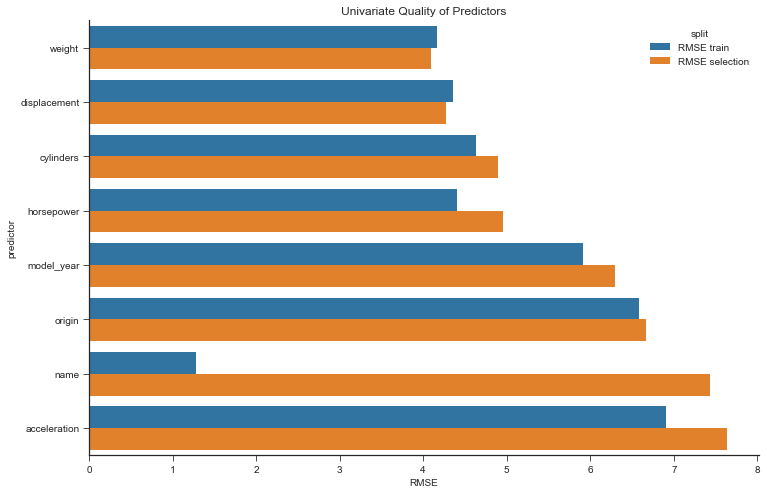

In [71]:
# TODO: this does not work yet for regression
from cobra.evaluation import plot_univariate_predictor_quality

# Plot df_rmse to get a horizontal barplot:
plot_univariate_predictor_quality(df_rmse)

Next, we compute correlations between the preprocessed predictors and plot it using a correlation matrix:


                origin      name  cylinders  model_year  horsepower  \
origin        1.000000  0.546835   0.572771    0.183962    0.481406   
name          0.546835  1.000000   0.809813    0.630115    0.820650   
cylinders     0.572771  0.809813   1.000000    0.430675    0.830014   
model_year    0.183962  0.630115   0.430675    1.000000    0.424169   
horsepower    0.481406  0.820650   0.830014    0.424169    1.000000   
displacement  0.665415  0.832378   0.908653    0.378712    0.869803   
acceleration  0.242806  0.468041   0.558839    0.285982    0.630786   
weight        0.631066  0.847656   0.879737    0.353530    0.877309   

              displacement  acceleration    weight  
origin            0.665415      0.242806  0.631066  
name              0.832378      0.468041  0.847656  
cylinders         0.908653      0.558839  0.879737  
model_year        0.378712      0.285982  0.353530  
horsepower        0.869803      0.630786  0.877309  
displacement      1.000000      0.530417  

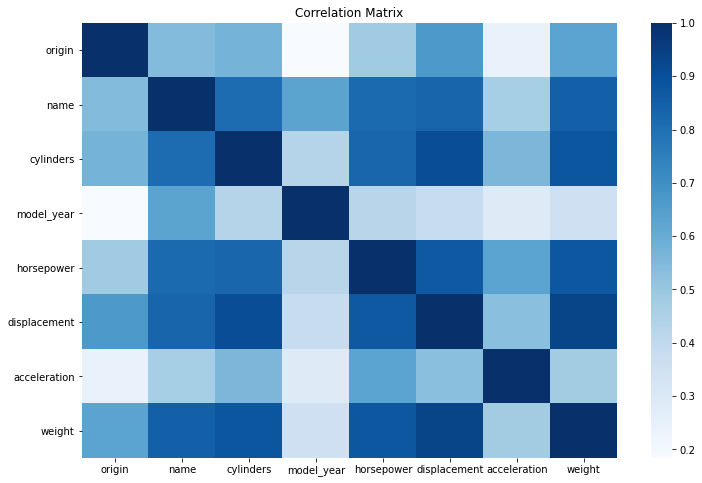

In [72]:
from cobra.evaluation import plot_correlation_matrix

# compute correlations between preprocessed predictors:
df_corr = (univariate_selection
           .compute_correlations(basetable[basetable["split"] == "train"],
                                 preprocessed_predictors))
print(df_corr)

# plot correlation matrix
plot_correlation_matrix(df_corr)

To get a list of the selected predictors after the univariate selection, run the following call:


In [73]:
preselected_predictors = (univariate_selection
                          .get_preselected_predictors(df_rmse))
preselected_predictors

['weight_enc',
 'displacement_enc',
 'cylinders_enc',
 'horsepower_enc',
 'model_year_enc',
 'origin_enc',
 'name_enc',
 'acceleration_enc']

After an initial preselection on the predictors, we can start building the model itself using forward feature selection to choose the right set of predictors. Since we use target encoding on all our predictors, we will only consider models with positive coefficients (no sign flip should occur) as this makes the model more interpretable.

## Modeling

Based on the performance curves (AUC per model with a particular number of predictors in case of logistic regression), a final model can then be chosen and the variables importance can be plotted:
Note: variable importance is based on correlation of the predictor with the model scores (and not the true labels!).

In [85]:
from cobra.model_building import ForwardFeatureSelection

forward_selection = ForwardFeatureSelection(model_type="regression",
                                            #model_name="linear-regression",
                                            max_predictors=30,
                                            pos_only=True)

# fit the forward feature selection on the train data
# has optional parameters to force and/or exclude certain predictors (see docs)
forward_selection.fit(basetable[basetable["split"] == "train"],
                      target_column_name = target_col,
                      predictors = preselected_predictors)
                      #forced_predictors: list = [],
                      #excluded_predictors: list = [])

# compute model performance
performances = (forward_selection
                .compute_model_performances(basetable, target_column_name = target_col))
performances

Sequentially adding best predictor...:   0%|          | 0/8 [00:00<?, ?it/s]

,predictors,last_added_predictor,train_performance,selection_performance,validation_performance,model_type
0,[name_enc],name_enc,1.280373,7.429626,6.833512,regression
1,"[name_enc, model_year_enc]",model_year_enc,1.240908,7.189859,6.638183,regression
2,"[name_enc, model_year_enc, weight_enc]",weight_enc,1.200362,6.588047,6.047175,regression
3,"[name_enc, model_year_enc, weight_enc, horsepo...",horsepower_enc,1.192404,6.546783,5.974150,regression
4,"[name_enc, model_year_enc, horsepower_enc, wei...",cylinders_enc,1.189153,6.561392,5.974802,regression
5,"[name_enc, model_year_enc, horsepower_enc, wei...",acceleration_enc,1.187192,6.551046,5.965723,regression
6,"[name_enc, model_year_enc, horsepower_enc, wei...",origin_enc,1.187033,6.546768,5.957807,regression
7,"[name_enc, model_year_enc, origin_enc, horsepo...",displacement_enc,1.186974,6.547338,5.955585,regression


As can be seen, we have completed 7 steps till no further improvement can be observed

C:\Users\hendrik.dewinter\PycharmProjects\cobra\cobra\evaluation\plotting_utils.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  ax.set_yticks(np.arange(0, max_metric*1.02, np.floor(max_metric/10)))


ValueError: Maximum allowed size exceeded

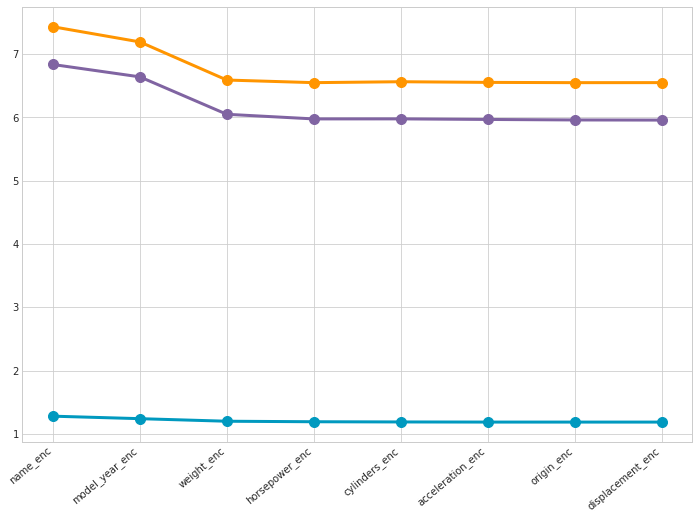

In [76]:
from cobra.evaluation import plot_performance_curves

# plot performance curves
plot_performance_curves(performances)

Based on the performance curves (AUC per model with a particular number of predictors in case of logistic regression), a final model can then be chosen and the variables importance can be plotted:


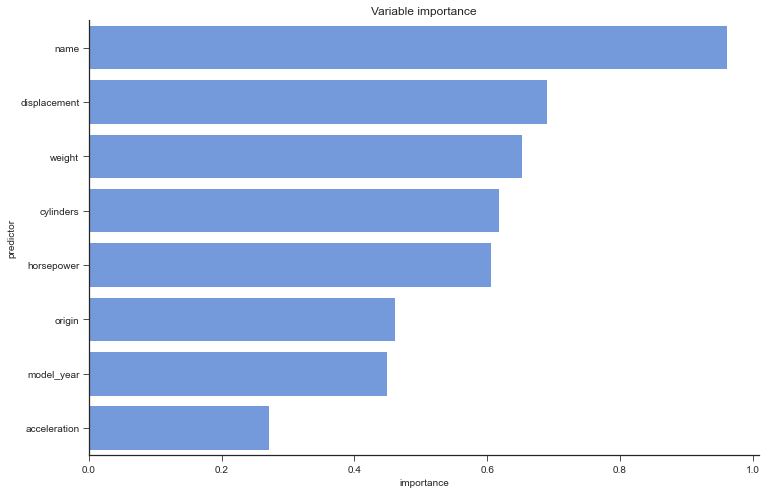

In [77]:
model = forward_selection.get_model_from_step(7)
final_predictors = model.predictors
final_predictors
from cobra.evaluation import plot_variable_importance
variable_importance = model.compute_variable_importance(
    basetable[basetable["split"] == "selection"])
plot_variable_importance(variable_importance)

Finally, we can again export the model to a dictionary to store it as JSON

In [78]:
model_dict = model.serialize()

model_path = os.path.join("output", "model.json")
with open(model_path, "w") as file:
    json.dump(model_dict, file)

# To reload the model again from a JSON file, run the following snippet:
# from cobra.model_building import LinearRegressionModel
# with open(model_path, "r") as file:
#     model_dict = json.load(file)
# model = LinearRegressionModel()
# model.deserialize(model_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'output\\model.json'

## Evaluation

Now that we have build and selected a final model, it is time to evaluate its predictions on the test set against various evaluation metrics. The used evaluation metrics are:
1. Coefficient of Determination: R2
2. Mean Absolute Error: MAE
3. Mean Squared Error: MSE
4. Root Mean Squared Error: RMSE

Furthermore, plotting makes the evaluation of a linear regression model a lot easier. We will use a **prediction plot**, which presents predictions from the model against actual values and a **Q-Q plot** from the standardized prediction residuals.

In [79]:
from cobra.evaluation import RegressionEvaluator
# get numpy array of True target labels and predicted scores:
y_true = basetable[basetable["split"] == "selection"][target_col].values
y_pred = model.score_model(basetable[basetable["split"] == "selection"])

In [80]:
evaluator = RegressionEvaluator()
evaluator.fit(y_true, y_pred)

In [81]:
evaluator.compute_scalar_metrics(y_true, y_pred)

R2       0.363109
MAE      4.927506
MSE     42.867631
RMSE     6.547338
dtype: float64

In [82]:
evaluator.compute_qq_residuals(y_true, y_pred)

quantiles    [-2.23653945714085, -1.9545779044793146, -1.77...
residuals    [-1.890723531717944, -1.874030710025782, -1.64...
dtype: object

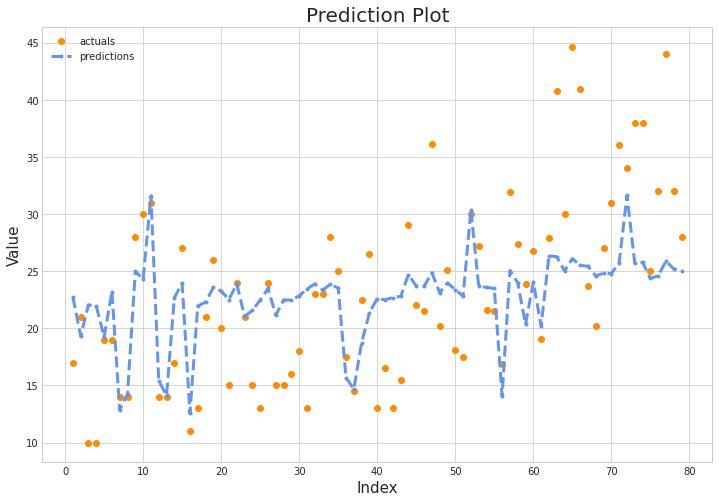

In [83]:
evaluator.plot_predictions(y_true=y_true, y_pred=y_pred)

ValueError: Illegal format string "o--."; two marker symbols

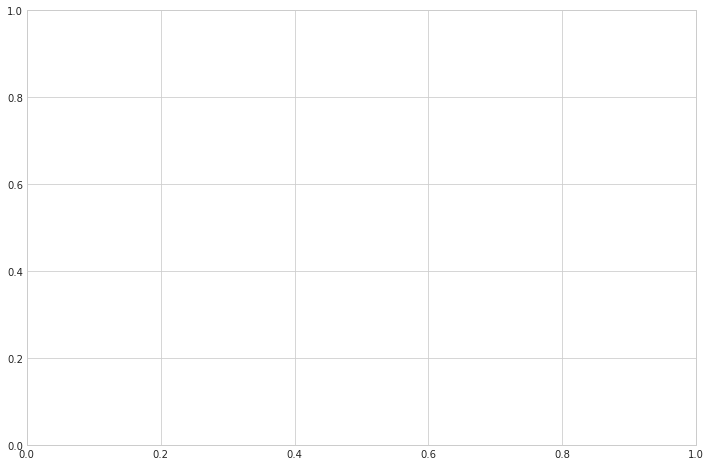

In [86]:
# does not work yet!
evaluator.plot_qq()